In [1]:
# Load required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read dataset from Excel file
glass_df = pd.read_excel("/content/glass.xlsx", sheet_name='glass')
glass_df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [4]:
# Basic exploratory checks
print("Top 5 records:")
print(glass_df.head())
print("\nInformation about dataset:")
print(glass_df.info())
print("\nDescriptive statistics:")
print(glass_df.describe())


Top 5 records:
        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1

Information about dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9)

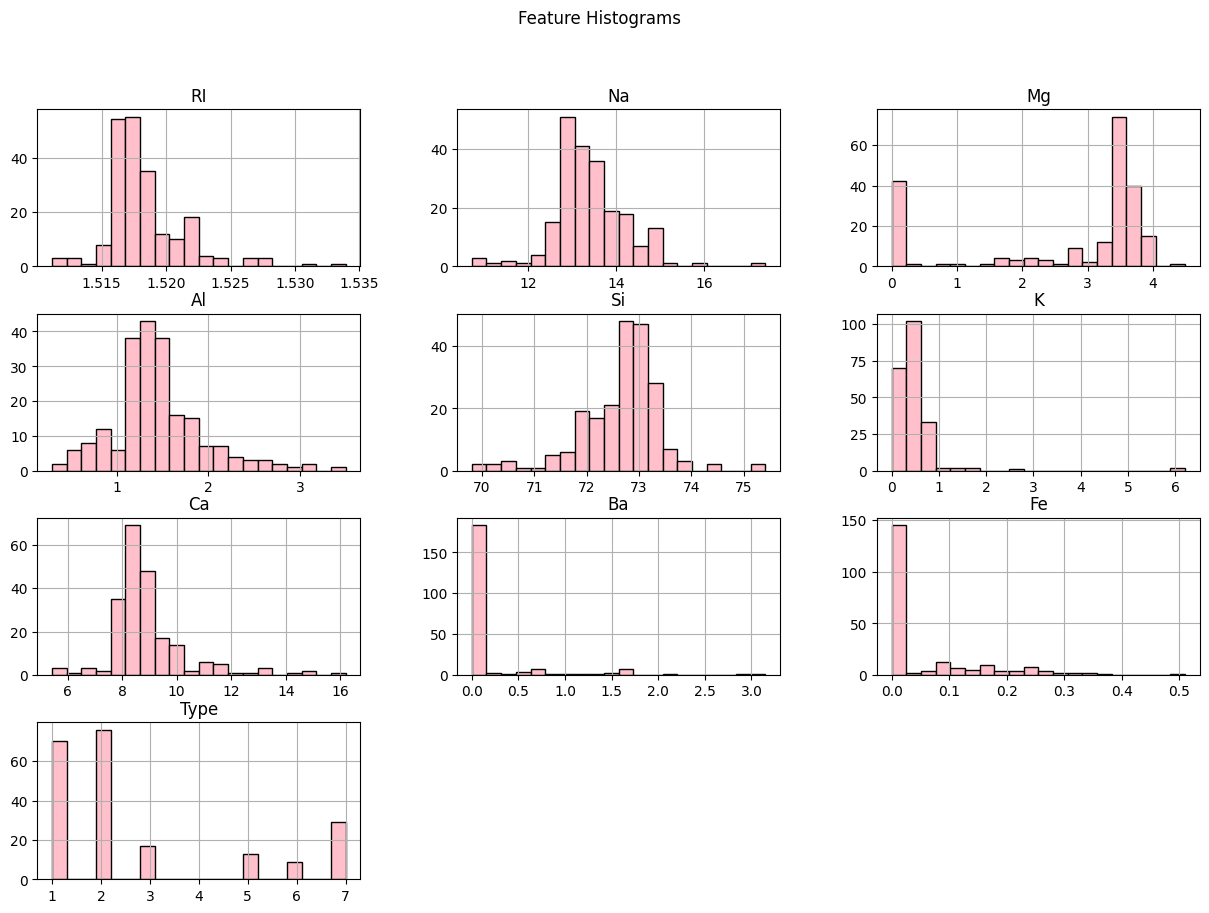

In [6]:
# Visual overview: histograms for each numeric column
glass_df.hist(bins=20, figsize=(15, 10), edgecolor='black',color='pink')
plt.suptitle("Feature Histograms")
plt.show()


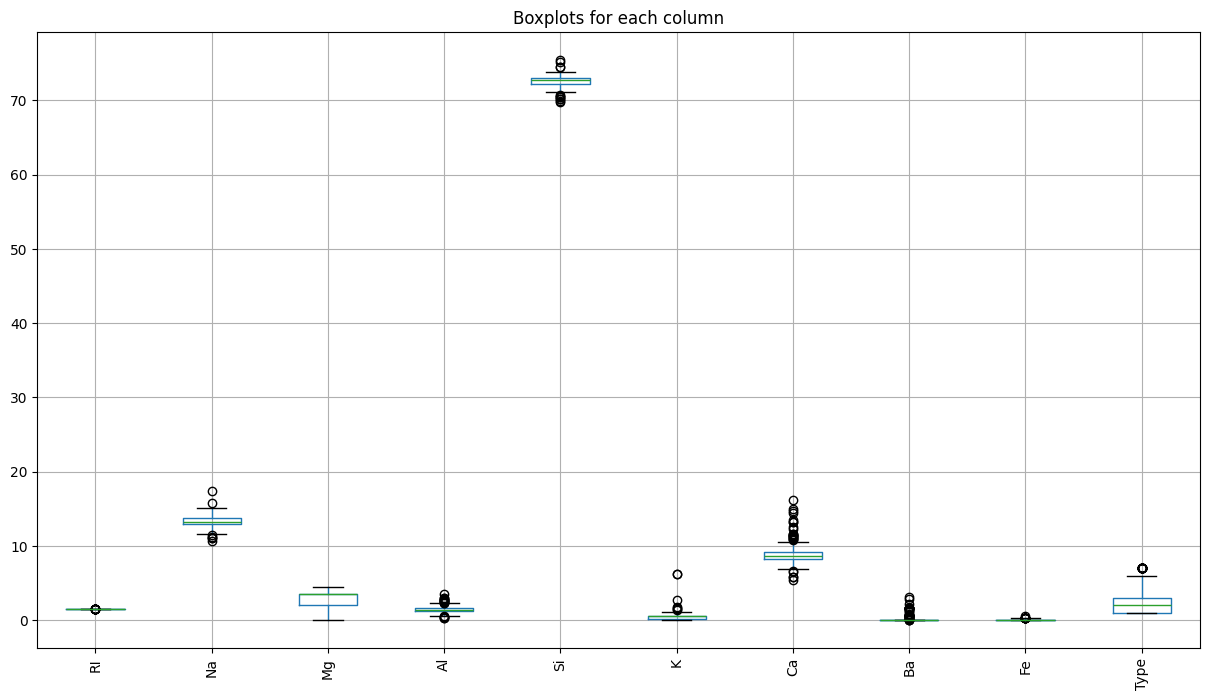

In [7]:
# Visual check for outliers using boxplots
plt.figure(figsize=(15, 8))
glass_df.boxplot(rot=90)
plt.title("Boxplots for each column")
plt.show()

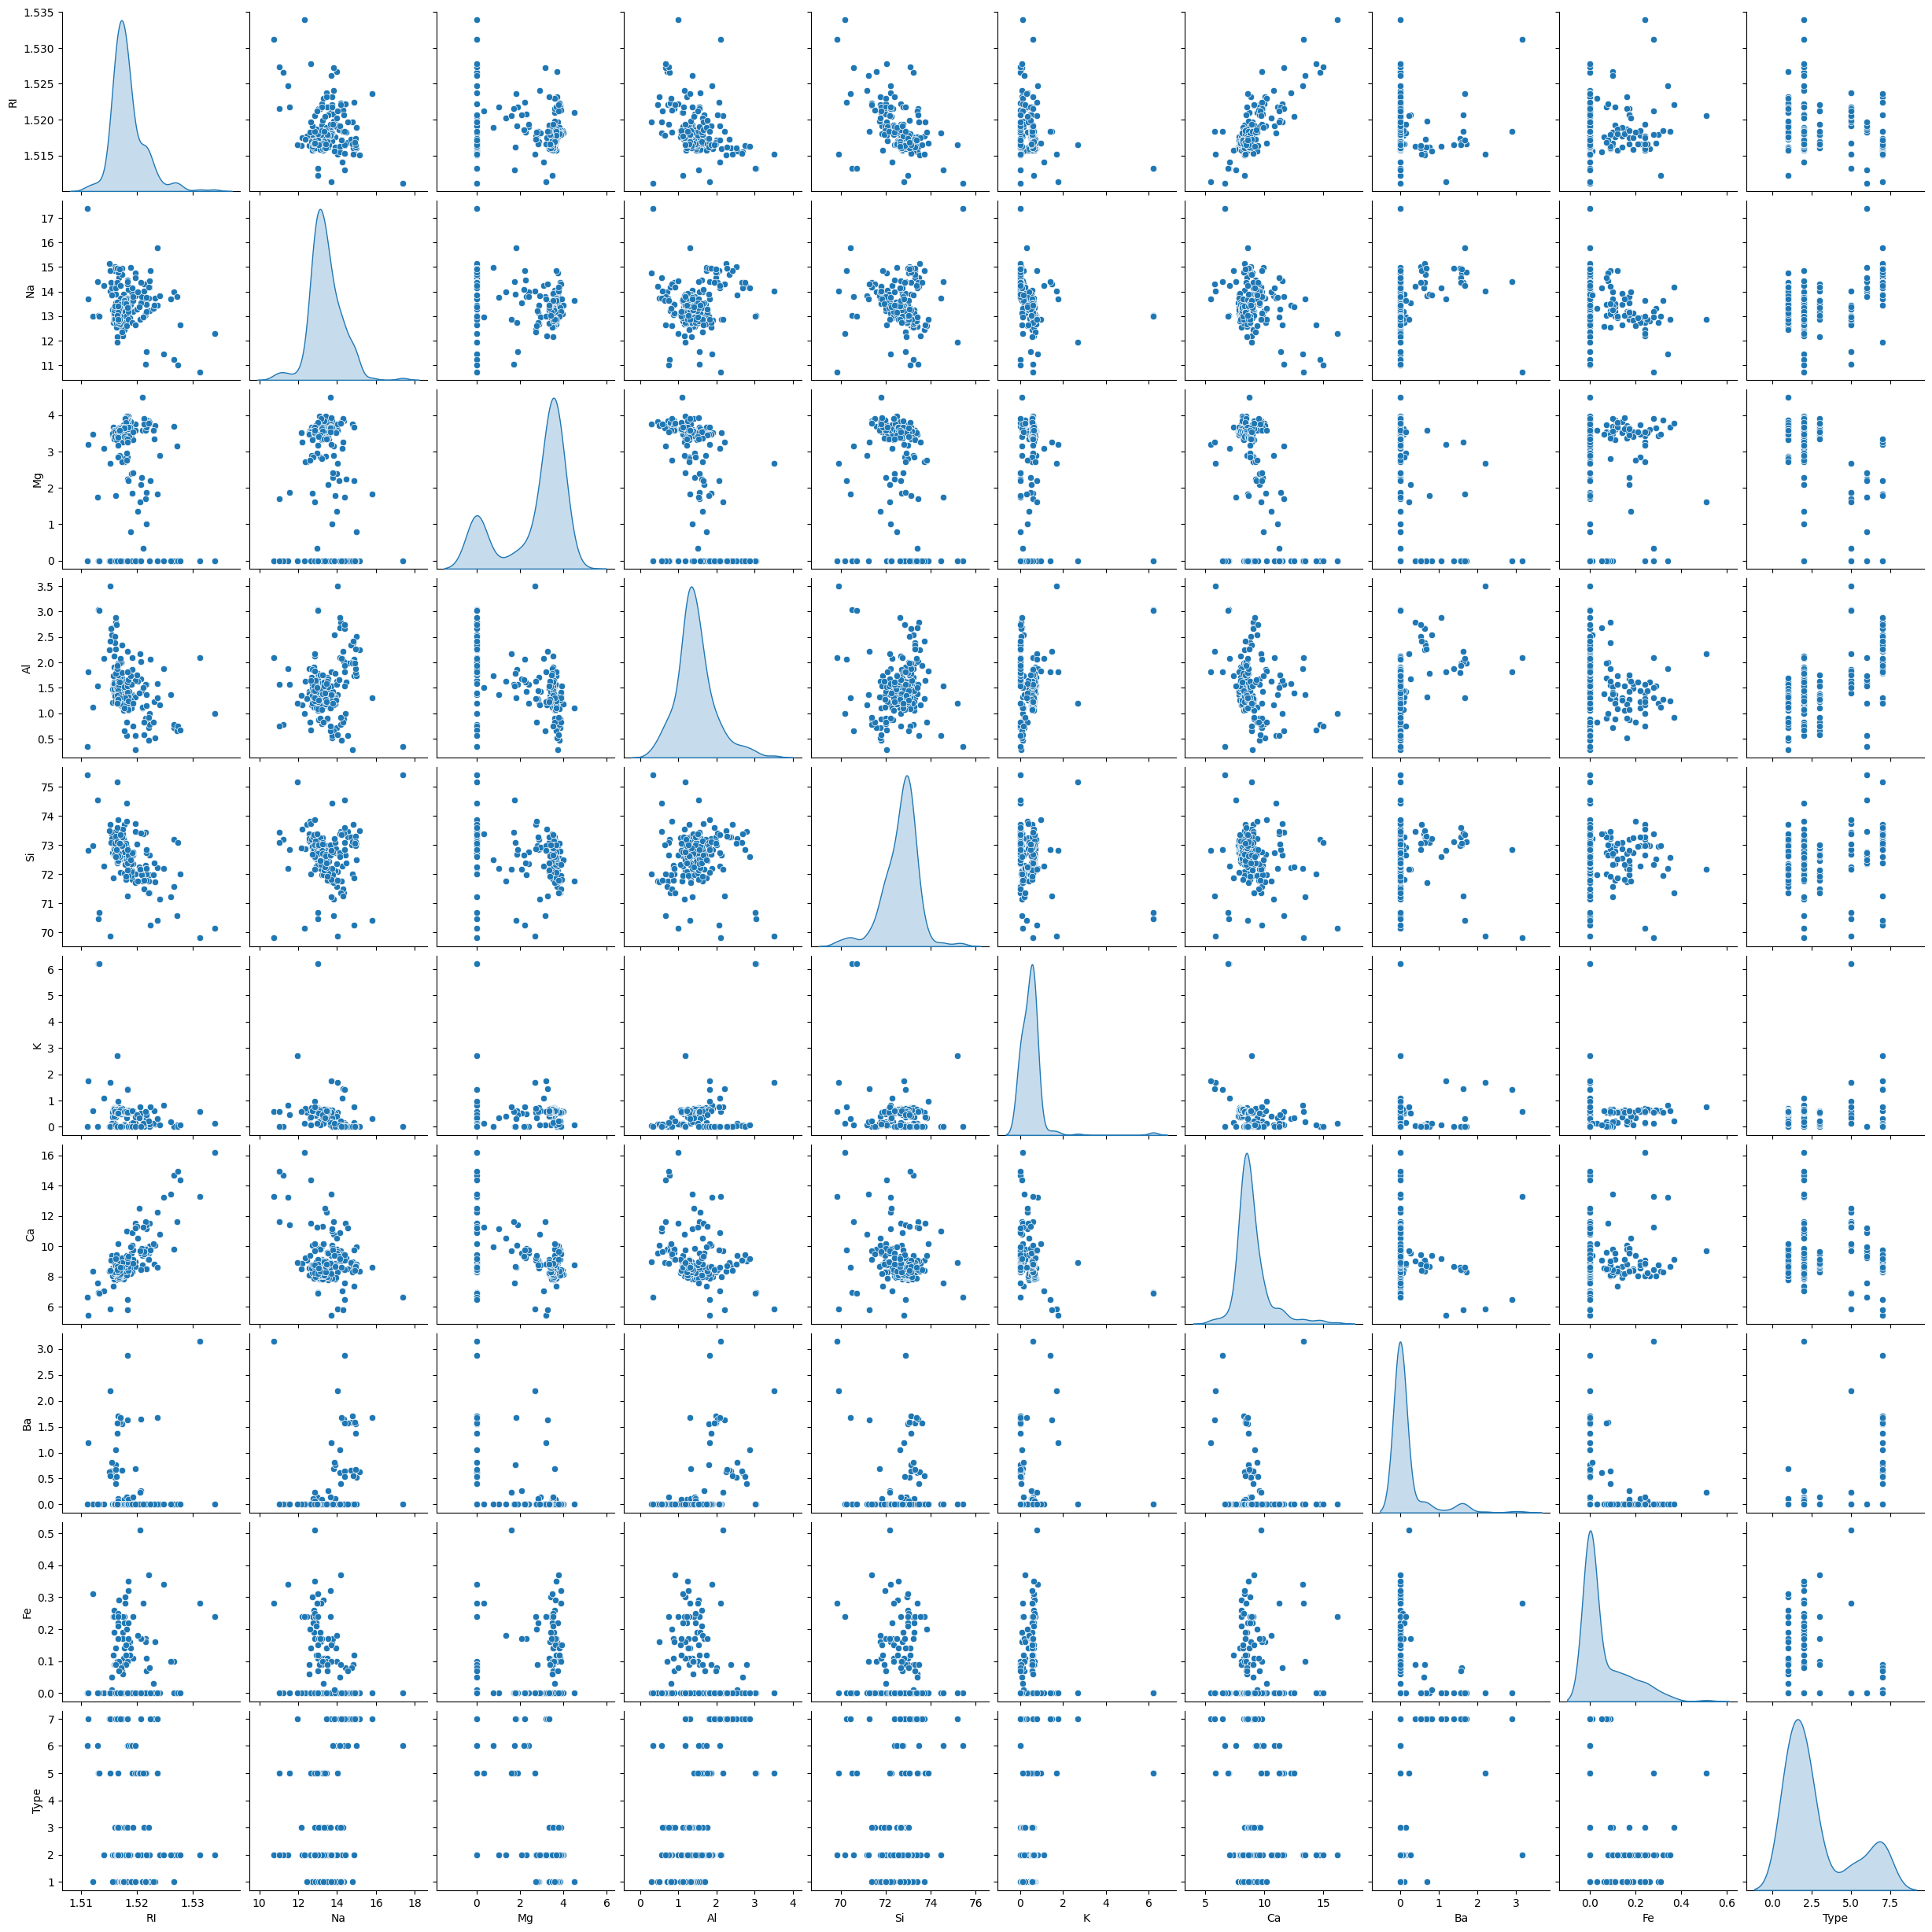

In [8]:
# Pairwise plots to inspect relationships between variables
sns.pairplot(glass_df, diag_kind='kde')
plt.show()

In [9]:
# Detect and remove extreme values using IQR rule
Q1 = glass_df.quantile(0.25)
Q3 = glass_df.quantile(0.75)
IQR = Q3 - Q1

In [10]:
# rows that are NOT outliers according to IQR across any column
non_outlier_mask = ~((glass_df < (Q1 - 1.5 * IQR)) | (glass_df > (Q3 + 1.5 * IQR))).any(axis=1)
print("Shape before dropping outliers:", glass_df.shape)
glass_df = glass_df[non_outlier_mask]
print("Shape after dropping outliers:", glass_df.shape)


Shape before dropping outliers: (214, 10)
Shape after dropping outliers: (136, 10)


In [11]:
# Check missing values and dtypes after outlier filtering
print("Null counts by column:\n", glass_df.isnull().sum())
print("\nColumn data types:\n", glass_df.dtypes)

Null counts by column:
 RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

Column data types:
 RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object


In [12]:
# If any text/categorical columns exist, convert them to numeric labels
text_cols = glass_df.select_dtypes(include=['object']).columns
if len(text_cols) > 0:
    encoder = LabelEncoder()
    for c in text_cols:
        glass_df[c] = encoder.fit_transform(glass_df[c])
print("Categorical columns encoded where necessary.")

Categorical columns encoded where necessary.


In [13]:
# Scale numerical features
scaler = StandardScaler()
features = glass_df.drop('Type', axis=1)
labels = glass_df['Type']
features_scaled = scaler.fit_transform(features)
print("Applied StandardScaler to feature set.")
features_scaled


Applied StandardScaler to feature set.


array([[ 1.83579391,  0.8327923 ,  1.9519404 , ...,  0.21006335,
         0.        , -0.59881868],
       [-0.14782787,  1.34835928,  0.33503056, ..., -1.25499387,
         0.        , -0.59881868],
       [-0.98211585,  0.60594283,  0.24419293, ..., -1.33461654,
         0.        , -0.59881868],
       ...,
       [ 0.24889649,  2.52385199, -2.13575302, ...,  1.02221463,
         0.        , -0.59881868],
       [ 0.38308267,  1.76081286, -2.22659065, ...,  1.11776184,
         0.        , -0.59881868],
       [ 0.59311321,  3.61685398, -4.78821185, ...,  2.12100755,
         0.        , -0.59881868]])

In [14]:
# Demonstrate oversampling to address class imbalance (SMOTE)
# using k_neighbors=1 because some classes have very few examples
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(features_scaled, labels)
print("Class distribution BEFORE SMOTE:")
print(labels.value_counts())
print("\nClass distribution AFTER SMOTE:")
print(y_resampled.value_counts())

Class distribution BEFORE SMOTE:
Type
1    59
2    55
3    15
6     5
5     2
Name: count, dtype: int64

Class distribution AFTER SMOTE:
Type
1    59
2    59
3    59
5    59
6    59
Name: count, dtype: int64


In [15]:
# Quick dataset introspection (repeating some checks for convenience)
print("Dataset shape:", glass_df.shape)
print("Column names:", glass_df.columns.tolist())
print("\nInfo:")
print(glass_df.info())
print("\nSummary stats:")
print(glass_df.describe())

Dataset shape: (136, 10)
Column names: ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, 0 to 181
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      136 non-null    float64
 1   Na      136 non-null    float64
 2   Mg      136 non-null    float64
 3   Al      136 non-null    float64
 4   Si      136 non-null    float64
 5   K       136 non-null    float64
 6   Ca      136 non-null    float64
 7   Ba      136 non-null    float64
 8   Fe      136 non-null    float64
 9   Type    136 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 11.7 KB
None

Summary stats:
               RI          Na          Mg          Al          Si           K  \
count  136.000000  136.000000  136.000000  136.000000  136.000000  136.000000   
mean     1.517863   13.236176    3.415588    1.344044   72.693309    0.499044   
std      0.001720    0.486696    

In [16]:
# Show dtypes and check for missing values again
print("\nDtypes:\n", glass_df.dtypes)
print("\nMissing value check:\n", glass_df.isnull().sum())



Dtypes:
 RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

Missing value check:
 RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64


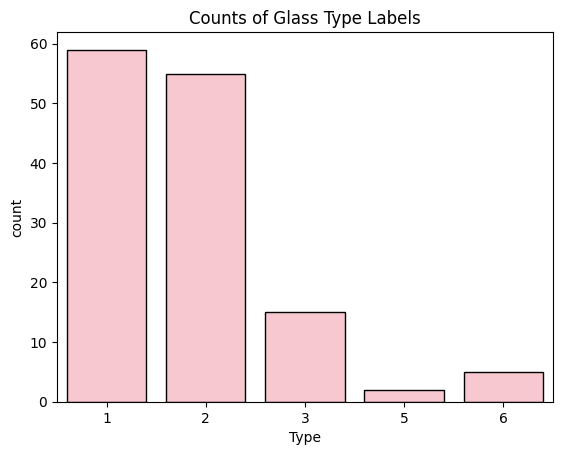

In [29]:
# Visualize the frequency of target classes
sns.countplot(x='Type', data=glass_df,color='pink', edgecolor='black')
plt.title("Counts of Glass Type Labels")
plt.show()

In [19]:
# Prepare features and label for modelling (using filtered dataset)
X = glass_df.drop('Type', axis=1)
y = glass_df['Type']


In [22]:
# Split into training and test portions, preserving class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (108, 9)
Test shape: (28, 9)


In [23]:
# Train a Random Forest classifier (baseline)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
# Evaluate Random Forest on the held-out test set
rf_preds = rf_clf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("\nRandom Forest - Classification Report:\n", classification_report(y_test, rf_preds))
print("\nRandom Forest - Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))

Random Forest Accuracy: 0.8571428571428571

Random Forest - Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.92      0.92        12
           2       0.79      1.00      0.88        11
           3       1.00      0.33      0.50         3
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         1

    accuracy                           0.86        28
   macro avg       0.74      0.65      0.66        28
weighted avg       0.84      0.86      0.83        28


Random Forest - Confusion Matrix:
 [[11  1  0  0  0]
 [ 0 11  0  0  0]
 [ 1  1  1  0  0]
 [ 0  1  0  0  0]
 [ 0  0  0  0  1]]


In [25]:
# Inspect feature importances from the Random Forest
feat_importances = rf_clf.feature_importances_
feat_names = X.columns

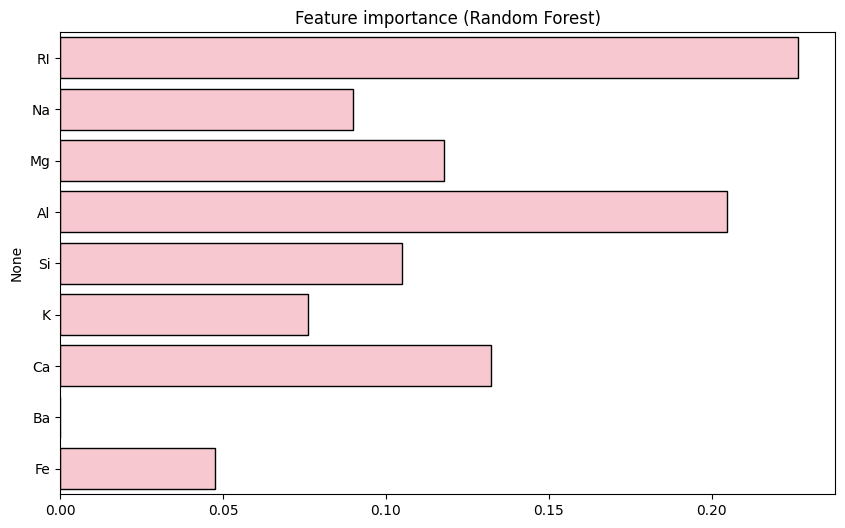

In [28]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances, y=feat_names, color='pink', edgecolor='black')
plt.title("Feature importance (Random Forest)")
plt.show()

In [30]:
# Apply Bagging of decision trees
bagger = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42
)
bagger.fit(X_train, y_train)
bagging_preds = bagger.predict(X_test)
print("Bagging classifier accuracy:", accuracy_score(y_test, bagging_preds))


Bagging classifier accuracy: 0.8571428571428571


In [31]:
# Apply AdaBoost (a boosting approach)
adaboost_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    random_state=42
)
adaboost_clf.fit(X_train, y_train)
boosting_preds = adaboost_clf.predict(X_test)
print("AdaBoost accuracy:", accuracy_score(y_test, boosting_preds))

AdaBoost accuracy: 0.75


In [32]:
# Compare all three model accuracies side-by-side
print("Summary of accuracies on test set:")
print("Random Forest:", accuracy_score(y_test, rf_preds))
print("Bagging:", accuracy_score(y_test, bagging_preds))
print("Boosting (AdaBoost):", accuracy_score(y_test, boosting_preds))

Summary of accuracies on test set:
Random Forest: 0.8571428571428571
Bagging: 0.8571428571428571
Boosting (AdaBoost): 0.75


# ## Q1 — Short explanation: Bagging vs Boosting
 **Bagging (Bootstrap Aggregation):**
-Multiple models are trained independently on different bootstrap samples and their outputs are averaged or voted on.
- It mainly lowers variance and helps stabilize high-variance learners like trees.
- Random Forest is a form of bagging with extra feature randomness.

# - **Boosting:**
- Models are built sequentially; each new learner focuses on correcting mistakes made by previous learners.
- It primarily reduces bias and can produce a strong predictor from weak learners.
- Examples include AdaBoost and Gradient Boosting.

# **Core difference:** bagging trains models in parallel to reduce variance; boosting trains models sequentially to reduce bias.

# ## Q2 — Ways to manage class imbalance
 1. **Resampling methods:** Oversample the minority (SMOTE) or undersample the majority class.  
 2. **Class weighting:** Give higher penalty/weight to minority classes in the loss function.  
 3. **Use specialized ensembles:** Balanced Random Forest or boosting variants that account for imbalance.  
 4. **Appropriate metrics:** Use precision, recall, F1 (macro/micro), and per-class recall instead of raw accuracy.